In [2]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')


device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


# Get experiment to find edges

In [3]:
from acdc.docstring.utils import get_all_docstring_things
from acdc.TLACDCExperiment import TLACDCExperiment
all_docstring_items = get_all_docstring_things(num_examples=40, seq_len=5, device=device, metric_name='docstring_metric', correct_incorrect_wandb=False)

model = all_docstring_items.tl_model
test_metrics = all_docstring_items.test_metrics['docstring_metric']
test_data = all_docstring_items.test_data
test_patch_data = all_docstring_items.test_patch_data

exp = TLACDCExperiment(
            model=model,
            threshold=0,
            ds=test_data,
            ref_ds=test_patch_data,
            metric=test_metrics,
            run_name=None,
        )
exp.model.reset_hooks()
exp.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False
)

del all_docstring_items

Loaded pretrained model attn-only-4l into HookedTransformer
Moving model to device:  cuda


ln_final.hook_normalized
ln_final.hook_scale
blocks.3.hook_resid_post
blocks.3.hook_attn_out
blocks.3.attn.hook_result
blocks.3.attn.hook_z
blocks.3.attn.hook_pattern
blocks.3.attn.hook_attn_scores
blocks.3.attn.hook_v
blocks.3.attn.hook_k
blocks.3.attn.hook_q
blocks.3.ln1.hook_normalized
blocks.3.ln1.hook_scale
blocks.3.hook_v_input
blocks.3.hook_k_input
blocks.3.hook_q_input
blocks.3.hook_resid_pre
blocks.2.hook_resid_post
blocks.2.hook_attn_out
blocks.2.attn.hook_result
blocks.2.attn.hook_z
blocks.2.attn.hook_pattern
blocks.2.attn.hook_attn_scores
blocks.2.attn.hook_v
blocks.2.attn.hook_k
blocks.2.attn.hook_q
blocks.2.ln1.hook_normalized
blocks.2.ln1.hook_scale
blocks.2.hook_v_input
blocks.2.hook_k_input
blocks.2.hook_q_input
blocks.2.hook_resid_pre
blocks.1.hook_resid_post
blocks.1.hook_attn_out
blocks.1.attn.hook_result
blocks.1.attn.hook_z
blocks.1.attn.hook_pattern
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_v
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.ln1.hook_nor

# Clean collected data, gather heads and edges

In [3]:
def clean_pruned_heads(pruned_heads):
    cleaned_heads = {}

    for thresh in pruned_heads.keys():
        cleaned_heads[thresh] = {}
        cleaned_heads[thresh]['acdcpp'] = set()
        cleaned_heads[thresh]['acdc'] = set()

        for i in range(2):
            for head in pruned_heads[thresh][i]:
                attn_head_pttn = re.compile('^<a([0-9]+)\.([0-9]+)>$')
                matched = attn_head_pttn.match(head)
                if matched:
                    head_str = f'{matched.group(1)}.{matched.group(2)}'
                    if i == 0:
                        cleaned_heads[thresh]['acdcpp'].add(head_str)
                    else:
                        cleaned_heads[thresh]['acdc'].add(head_str)
    return cleaned_heads

def get_all_heads(num_layers, num_heads):
    all_heads = set()

    for layer in range(num_layers):
        for head in range(num_heads):
            all_heads.add(f'{layer}.{head}')
    return all_heads

In [4]:
from acdc.docstring.utils import get_docstring_subgraph_true_edges
from utils.prune_utils import parse_relevant_edges

RUN_NAME = 'abs_edges'

with open(f'{RUN_NAME}_pruned_heads.json', 'r') as f:
    pruned_heads = json.load(f)
with open(f'{RUN_NAME}_pruned_attrs.json', 'r') as f:
    pruned_attrs = json.load(f)
with open(f'{RUN_NAME}_num_passes.json', 'r') as f:
    num_passes = json.load(f)
    
# NODES
docstring_heads = set(['0.1', '0.2', '0.4', '0.5', '1.2', '1.4', '2.0', '2.3', '3.0', '3.6'])
print(len(docstring_heads))

pruned_heads = clean_pruned_heads(pruned_heads)

# 4 layers, 8 head model
all_heads = get_all_heads(4, 8)

# EDGES
all_edges = parse_relevant_edges(exp)

# Get pruned edges
with open(f'{RUN_NAME}_edges_after_acdcpp.json', 'r') as f:
    edges_after_acdcpp = json.load(f)
with open(f'{RUN_NAME}_edges_after_acdc.json', 'r') as f:
    edges_after_acdc = json.load(f)

for threshold in edges_after_acdcpp.keys():
    edges_after_acdcpp[threshold] = set(edges_after_acdcpp[threshold])
    edges_after_acdc[threshold] = set(edges_after_acdc[threshold])

attrs = []
for _,_,_,_,attr in pruned_attrs[list(pruned_attrs.keys())[0]]:
    attrs.append(attr)
# Get true edges
true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]').replace('None', ':')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{child_name}{replace_parens(child_idx)}{parent_name}{replace_parens(parent_idx)}')

10


Edge pruning: 100%|██████████| 193/193 [00:00<00:00, 21825.31it/s]


In [15]:
attrs.sort()
np.quantile(attrs, [0,.25,.50,.75,.95, 1])

array([0.00000000e+00, 1.14791351e-03, 4.88377968e-03, 1.94272548e-02,
       2.22061718e-01, 4.55413342e+00])

# Validate edge data

In [19]:
# pruned_edges, true_edges should all be in all_edges
for threshold in edges_after_acdcpp.keys():
    for missing_edge in (edges_after_acdcpp[threshold] - all_edges):
        print(missing_edge)
    for missing_edge in (edges_after_acdc[threshold] - all_edges):
        print(missing_edge)
        
print('ACDC++ edge test complete')
print('ACDC edge test complete')
for missing_edge in (true_edges - all_edges):
    true_edges.remove(missing_edge)
    print(missing_edge)

ACDC++ edge test complete
ACDC edge test complete


# Calculate Metrics

In [20]:
data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
    'TPR': [1],
    'TNR': [0],
    'FPR': [1],
    'FNR': [0],
    'Num Passes': [np.inf],
}

for thresh in pruned_attrs.keys():
    data['Threshold'].append(thresh)
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_edges = edges_after_acdcpp[thresh]
    edges = edges_after_acdc[thresh]
    
    pp_tp = len(pp_edges.intersection(true_edges))
    pp_tn = len((all_edges - true_edges).intersection(all_edges - pp_edges))
    pp_fp = len(pp_edges - true_edges)
    pp_fn = len(true_edges - pp_edges)

    tp = len(edges.intersection(true_edges))
    tn = len((all_edges - true_edges).intersection(all_edges - edges))
    fp = len(edges - true_edges)
    fn = len(true_edges - edges)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

    data['TPR'].append(tpr)
    data['TNR'].append(tnr)
    data['FPR'].append(fpr)
    data['FNR'].append(fnr)

    data['Num Passes'].append(num_passes[thresh])
df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1, 0, 1, 0, 1, 0]
df.loc[len(df)] = row

In [23]:
df

,Threshold,ACDCpp TPR,ACDCpp TNR,ACDCpp FPR,ACDCpp FNR,TPR,TNR,FPR,FNR,Num Passes
0,0,1.0,0.0,1.0,0.0,1.0,0.000000,1.000000,0.0,inf
1,0,1.0,0.0,1.0,0.0,1.0,0.551253,0.448747,0.0,961.0
2,inf,0.0,1.0,0.0,1.0,0.0,1.000000,0.000000,1.0,0.0


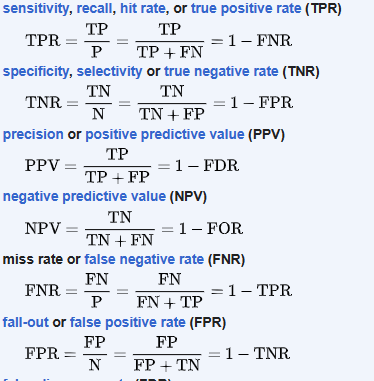

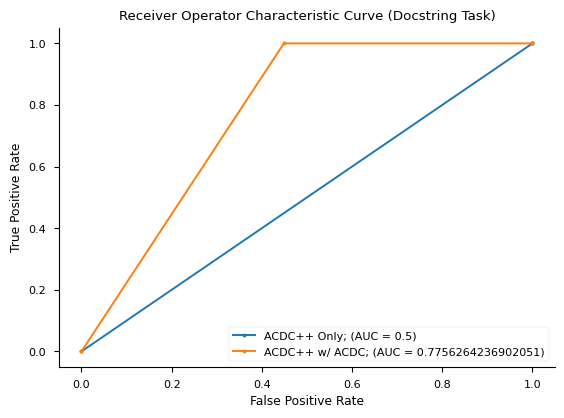

In [22]:
# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc

acdcpp_auc = auc(df['ACDCpp FPR'], df['ACDCpp TPR'])
acdc_auc = auc(df['FPR'], df['TPR'])

plt.plot(df['ACDCpp FPR'], df['ACDCpp TPR'], marker='.', label=f'ACDC++ Only; (AUC = {acdcpp_auc})')
plt.plot(df['FPR'], df['TPR'], marker='.', label=f'ACDC++ w/ ACDC; (AUC = {acdc_auc})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curve (Docstring Task)')
plt.legend()
#plt.gca().invert_xaxis()

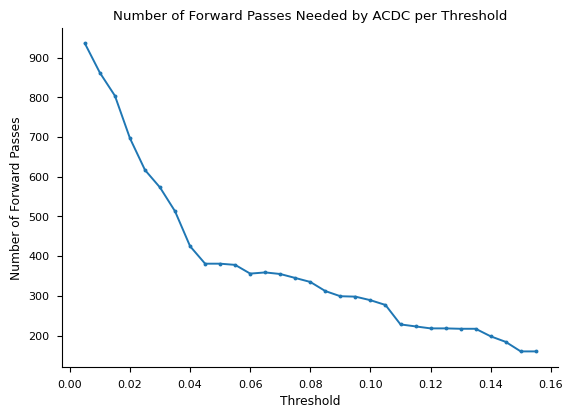

In [21]:
plt.plot(df['Threshold'], df['Num Passes'], marker='.')
plt.xlabel('Threshold')
plt.ylabel('Number of Forward Passes')
plt.title('Number of Forward Passes Needed by ACDC per Threshold')
plt.show()